In [4]:
#imports
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random as random
import statistics as st
from enum import Enum
from mesa_geo import GeoSpace
from mesa_geo.geoagent import GeoAgent, AgentCreator
from shapely.geometry import Point, Polygon
import json 
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import pyproj
import math
import numpy as np
import os
from mesa.batchrunner import BatchRunner
%matplotlib inline

In [5]:
chicago = gpd.read_file('Community Areas')
chicago.set_index(chicago['area_num_1'])
chicago.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."


In [6]:
#read in NETS food store CSV and create geometry from latitude and longitude values
fs = pd.read_csv('AttributesAssigned_correctedlongitude.csv')
crs = "EPSG:4326"
geometry = [Point(xy) for xy in zip(fs["Longitude"], fs["Latitude"])]
geometry[:3]
fs.head()

,OBJECTID,pri_neigh,Company,Latitude,Longitude,STORETYPE,foodcost,quality,agent_type
0,1,Grand Boulevard,PIACERE MIO CAFE,41.8219,-87.6166,Restaurant,20.40,0.11,foodstore
1,2,Grand Boulevard,HONEY ONE BBQ,41.8168,-87.6076,Restaurant,16.47,0.12,foodstore
2,3,Grand Boulevard,AINT SHE SWEET CAFE,41.8167,-87.6131,Restaurant,8.45,0.75,foodstore
3,4,Grand Boulevard,MAGGIE GYROS & CHICKEN,41.8093,-87.6178,Restaurant,4.19,0.58,foodstore
4,5,Grand Boulevard,LOUS GOURMET SWEETS LLC,41.8069,-87.6126,Specialty,3.27,0.14,foodstore


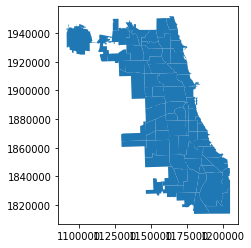

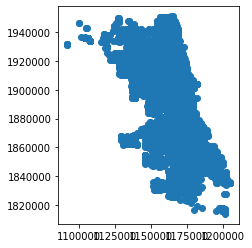

In [7]:
    #SET UP CHICAGO
chicago = gpd.read_file('Community Areas')
chicago.set_index(chicago['area_num_1'])
chicago = chicago.to_crs("EPSG:3435")
unique_id = 'area_num_1'
chicago.plot()
    
    #FOOD STORES FROM GEODATAFRAME ABOVE
geo_fs = gpd.GeoDataFrame(fs, crs=crs, geometry=geometry)
geo_fs.set_index(geo_fs['OBJECTID'])
geo_fs_3435 = geo_fs.to_crs("EPSG:3435")
fs_id = 'OBJECTID'
geo_fs_3435.plot()

In [13]:


#define agent properties and actions

#Food Stores
class FoodStore(GeoAgent):
    def __init__(self, unique_id, model, shape):
        super().__init__(unique_id, model, shape)
        self.shape = shape

    def step(self):
        pass
        
        
#Chicago Neighborhoods
class NeighborhoodAgent(GeoAgent):
    def __init__(self, unique_id, model, shape):
        super().__init__(unique_id, model, shape)
        
    def step(self):
        pass

        
#People
class PersonAgents(GeoAgent):
    def __init__(self, unique_id, model, shape, FV, stress, foodpref, age, sex, race, income, foodbudget, agent_type, FV_Total):
        super().__init__(unique_id, model, shape)
        # vars for initialization
        self.stress = round(stress, 2)
        self.foodpref = round(foodpref, 2)
        self.age = age
        self.sex = sex
        self.race = race
        self.income = income
        self.foodbudget = round(foodbudget, 2)
        self.shape = shape
        self.agent_type = agent_type
        self.FV = FV
        self.FV_Total = FV_Total
        
    
    def Actions(self):
        #Store friends' preferences
        friends = []
        PA_Neighbors = self.model.grid.get_neighbors_within_distance(self, self.model.PA_distance) #PERSON AGENT NEIGHBORS (PA_Neighbors)
        for f in PA_Neighbors:
            if isinstance (f, PersonAgents):
                friends.append(f.foodpref)
        friendspref = st.mean(friends)
        
        #Chose a food store from neighboring options
        Options = [] #Empty list of store options
        FS_Neighbors = self.model.grid.get_neighbors_within_distance(self, self.model.FS_distance) #Collects all neighbors w/in set distance
        for x in FS_Neighbors:
            if isinstance (x, FoodStore):
                if (
                    (self.foodpref - self.model.BSPR) <= x.quality <= (self.foodpref + self.model.BSPR) #IF QUALITY ALMOST MATCHES PREFERENCE
                    and
                    (x.foodcost <= (self.foodbudget + (self.model.BS * self.foodbudget)) ) #CONDITIONAL BUDGET STRETCH (stretch an additional proportion of budget)
                ):
                    Verdict = "EAT HERE - BUDGET STRETCH"
                    Options.append(x.quality) #add these restaurants healthful score to viable options 
                elif (
                    (x.foodcost <= self.foodbudget) #within budget
                    and 
                    (self.foodpref - self.model.WBPR) <= x.quality <= (self.foodpref + self.model.WBPR) #preference range (+/- WBPR)
                ):
                    Verdict = "EAT HERE"
                    Options.append(x.quality) #add these restaurants healthful score to viable options
                else:
                    Verdict = "DONT EAT HERE" #CANT AFFORD & NOT WORTH STRETCHING BUDGET FOR
        
        if len(Options) == 0: #if no stores to choose from, no FV eaten, no update to preferences
            self.FV = 0
        elif Options:
            Choice = random.choice(Options) #randomly choose one store from available options
            
        #FV intake
            if self.foodpref > Choice:
                self.FV = Choice * self.model.FVI #agents have the opportunity to eat rec amt each eating event
            else:
                self.FV = self.foodpref * Choice * self.model.FVI #proportion of what is available at FS
            
            
            
        #Combine inlfuences to update preferences
            #1: calculate environmental and social influenecs
            InfENV = ((Choice + self.stress) / 2) #averaging food choice and stress level
            InfSOC = ((self.foodpref + friendspref) / 2) #averaging own preferences with friends'
            
            #2: combine influences (mean of food preferences, environmental, and social influences)
            Influence = round(((self.foodpref + InfENV + InfSOC) / 3), 3)
            
            #Thresholds for change = 10%
            Tup = (self.foodpref + (0.10 * self.foodpref)) #UPPER THRESHOLD
            Tlow = (self.foodpref - (0.10 * self.foodpref)) #LOWER THRESHOLD
        
            #3: UPDATE PREFERENCES
            if Influence >= Tup:
                self.foodpref = round((self.foodpref * 1.01), 2)
            elif Influence <= Tlow:
                self.foodpref = round((self.foodpref * 0.99), 2)
            else:
                self.foodpref = round(self.foodpref, 2)
                

    def step(self):
        self.Actions()
        self.FV_Total += self.FV
    



#MODEL:
#define model sequence
class FVModel(Model):

    #SET UP CHICAGO
    chicago = gpd.read_file('Community Areas')
    chicago.set_index(chicago['area_num_1'])
    chicago = chicago.to_crs("EPSG:3435")
    unique_id = 'area_num_1'
    
    #FOOD STORES FROM GEODATAFRAME ABOVE
    geo_fs = gpd.GeoDataFrame(fs, crs=crs, geometry=geometry)
    geo_fs.set_index(geo_fs['OBJECTID'])
    geo_fs_3435 = geo_fs.to_crs("EPSG:3435")
    fs_id = 'OBJECTID'
    

    #INITIALIZE MODEL    
    def __init__(self, N, FS_distance, PA_distance, BSPR, WBPR, FVI, BS):#, fig_ax = None):
     #   if fig_ax is None: fig_ax = plt.subplots()
     #   fig, ax = fig_ax
        self.steps = 0
        self.schedule = RandomActivation(self)
        self.num_white = int(N * 0.33)
        self.num_black = int(N * 0.30)
        self.num_asian = int(N * 0.07)
        self.num_hispanic = int(N * 0.29)
        self.FS_distance = FS_distance  #distance to food stores
        self.PA_distance = PA_distance  #distance other person agents must be to be considered friends
        self.BSPR = BSPR  #BUDGET STRETCH PREFERENCE RANGE --> how close to preference to stretch budget (smaller number)
        self.WBPR = WBPR  #WITHIN BUDGET PREFERENCE RANGE --> typical food choise, within a wider range of preferences (larger number)
        self.FVI = FVI #FV INTAKE --> max number allowable to eat per event
        self.BS = BS #Budget stretch --> percent that will be multiplied by budget to increase amount available to spend at stores that closely align with preferences
        
        self.running=True
        self.datacollector = DataCollector(
            model_reporters={"agent_count":lambda m: m.schedule.get_agent_count()},
            agent_reporters=
                {
                    "ID": lambda a: a.unique_id,
                    "FV": lambda a: a.FV if isinstance (a, PersonAgents) else None,
                    "Race": lambda a: a.race if isinstance (a, PersonAgents) else None,
                    "Budget": lambda a: a.foodbudget if isinstance (a, PersonAgents) else None,
                    "Preference": lambda a: a.foodpref if isinstance (a, PersonAgents) else None
                },
            tables = {"FV_Count": {"step":[], "ID":[], "FVCount":[], "Race":[], "Budget":[], "Preference":[]}}
        )

        #ADD ALL Chicago NEIGHBORHOODS TO GRID:
        self.grid = GeoSpace(crs="EPSG:3435")
        AC = AgentCreator(NeighborhoodAgent, {"model": self}, crs="EPSG:3435")
        nb_agents = AC.from_GeoDataFrame(self.chicago, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(nb_agents)
        
       # NH White neighborhoods
        #MOST LIKELY = 0
        ChiWhite1 = chicago[(chicago['area_num_1'].isin(["72", "74", "9", "10", "24", "17", "5", "7", "6", "76", "11", "12", "4", "8", "32"]))]
        w1nb_agents = AC.from_GeoDataFrame(ChiWhite1, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(w1nb_agents)
        #1
        ChiWhite2 = chicago[(chicago['area_num_1'].isin(["55", "75", "56", "64", "22", "21", "18", "15", "1", "16", "3", "77", "41", "14", "28", "2", "33", "13", "60"]))]
        w2nb_agents = AC.from_GeoDataFrame(ChiWhite2, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(w2nb_agents)        
        #2
        ChiWhite3 = chicago[(chicago['area_num_1'].isin(["52", "50", "65", "70", "62", "19", "31", "61", "57", "39", "35", "59", "34"]))]
        w3nb_agents = AC.from_GeoDataFrame(ChiWhite3, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(w3nb_agents)        
        #3
        ChiWhite4 = chicago[(chicago['area_num_1'].isin(["37", "47", "51", "73", "40", "46", "67", "69", "26", "45", "48", "53", "68", "30", "43", "27", "38", "44", "49", "54", "71", "25", "63", "23", "66", "20", "36", "42", "58"]))]
        w4nb_agents = AC.from_GeoDataFrame(ChiWhite4, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(w4nb_agents) 

       # NH Black neighborhoods
        #MOST LIKELY = 0
        ChiBlack1 = chicago[(chicago['area_num_1'].isin(["71", "25", "45", "47", "48", "44", "27", "68", "37", "38", "69", "29", "36", "50", "54", "49", "43", "73", "40", "67", "26", "53", "42"]))]
        b1nb_agents = AC.from_GeoDataFrame(ChiBlack1, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(b1nb_agents)
        #1
        ChiBlack2 = chicago[(chicago['area_num_1'].isin(["70", "66", "35", "39", "75", "46", "51"]))]
        b2nb_agents = AC.from_GeoDataFrame(ChiBlack2, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(b2nb_agents)        
        #2
        ChiBlack3 = chicago[(chicago['area_num_1'].isin(["72", "23", "41", "33", "28", "61", "1", "3"]))]
        b3nb_agents = AC.from_GeoDataFrame(ChiBlack3, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(b3nb_agents)        
        #3
        ChiBlack4 = chicago[(chicago['area_num_1'].isin(["14", "57", "34", "21", "19", "60", "58", "64", "17", "52", "77", "9", "12", "63", "56", "55", "20", "16", "11", "6", "7", "4", "22", "32", "31", "59", "18", "74", "8", "5", "13", "10", "76", "15", "30", "62", "65", "2", "24"]))]
        b4nb_agents = AC.from_GeoDataFrame(ChiBlack4, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(b4nb_agents)
        
       # Asian neighborhoods
        #MOST LIKELY = 0
        ChiAsian1 = chicago[(chicago['area_num_1'].isin(["34"]))]
        a1nb_agents = AC.from_GeoDataFrame(ChiAsian1, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(a1nb_agents)
        #1
        ChiAsian2 = chicago[(chicago['area_num_1'].isin(["60", "33", "13", "2"]))]
        a2nb_agents = AC.from_GeoDataFrame(ChiAsian2, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(a2nb_agents)        
        #2
        ChiAsian3 = chicago[(chicago['area_num_1'].isin(["14", "58", "35", "77", "12", "41", "16", "11", "39", "6", "4", "32", "59", "8", "28", "76", "3"]))]
        a3nb_agents = AC.from_GeoDataFrame(ChiAsian3, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(a3nb_agents)        
        #3
        ChiAsian4 = chicago[(chicago['area_num_1'].isin(["57", "70", "71", "25", "45", "21", "19", "72", "47", "48", "44", "66", "64", "17", "27", "52", "9", "68", "37", "63", "56", "38", "69", "55", "20", "23", "7", "22", "31", "18", "75", "74", "61", "5", "29", "10", "36", "15", "50", "54", "1", "49", "46", "51", "30", "43", "73", "40", "62", "67", "26", "65", "53", "24", "42"]))]
        a4nb_agents = AC.from_GeoDataFrame(ChiAsian4, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(a4nb_agents)
        
       # Hispanic neighborhoods
        #MOST LIKELY = 0
        ChiHispanic1 = chicago[(chicago['area_num_1'].isin(["57", "19", "58", "52", "63", "20", "31", "30", "62", "65"]))]
        h1nb_agents = AC.from_GeoDataFrame(ChiHispanic1, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(h1nb_agents)
        #1
        ChiHispanic2 = chicago[(chicago['area_num_1'].isin(["14", "70", "21", "66", "64", "56", "55", "23", "16", "22", "59", "18", "61", "15"]))]
        h2nb_agents = AC.from_GeoDataFrame(ChiHispanic2, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(h2nb_agents)        
        #2
        ChiHispanic3 = chicago[(chicago['area_num_1'].isin(["25", "60", "17", "77", "12", "11", "4", "5", "13", "76", "1", "46", "51", "3", "2" "24"]))]
        h3nb_agents = AC.from_GeoDataFrame(ChiHispanic3, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(h3nb_agents)        
        #3
        ChiHispanic4 = chicago[(chicago['area_num_1'].isin(["34", "71", "45", "72", "47", "48", "44", "35", "27", "9", "68", "37", "38", "69", "41", "39", "6", "7", "32", "75", "74", "8", "33", "28", "29", "10", "36", "50", "54", "49", "43", "73", "40", "67", "26", "53", "42"]))]
        h4nb_agents = AC.from_GeoDataFrame(ChiHispanic4, unique_id=self.unique_id, set_attributes=True)
        self.grid.add_agents(h4nb_agents)
        
        
    #Food Stores
        s_population = AgentCreator(FoodStore, {"model": self}, crs="EPSG:3435")
        fs_agents = s_population.from_GeoDataFrame(self.geo_fs_3435, unique_id=self.fs_id, set_attributes=True)
        self.grid.add_agents(fs_agents)
        
        for store in fs_agents:
            #add to scheduler
            self.schedule.add(store)  
        
        #NEEDED FOR PLOTTING:
        agents_gpd = pd.DataFrame({'unique_id':[], 'type':[], 'geometry':[]})
          
        
    #PERSON AGENT CHARACTERISTICS
        
        #assign demographics per person agent
      # WHITE
        for i in range(self.num_white):
            agent_type = "person"
            FV = 0
            FV_Total = 0
            race = "White"
            
            #randomize sex, age, stress level, and food preference --> same for all race cats
            sexes = ('Male', 'Female')
            sex = random.choice(sexes)
            age = random.randrange(19, 78) #adults to life expectancy 18 to 77
            stress = random.random()
            foodpref = random.random()
            
            #INCOME AND FOOD BUDGET --> differs by race category 
            mi = 0         #min
            Q1 = 42315
            med = 87974   #median
            Q3 = 159880
            ma = 1632000   #max
        
            A = random.randrange(4)
            if A == 0:
                income = random.randrange(mi, Q1)
            elif A == 1:
                income = random.randrange(Q1, med)
            elif A == 2:
                income = random.randrange(med, Q3)
            elif A == 3:
                income = random.randrange(Q3, ma)
                
                
            #FOOD BUDGET - proportion of income; differs by income category
            if income < 15000:
                foodbudget = (income * random.uniform(0.122, 0.204))/365
            if income >= 15000 and income < 29999:
                foodbudget = (income * random.uniform(0.109, 0.177))/365
            if income >= 30000 and income < 39999:
                foodbudget = (income * random.uniform(0.105, 0.181))/365
            if income >= 40000 and income < 49999:
                foodbudget = (income * random.uniform(0.097, 0.171))/365
            if income >= 50000 and income < 69999:
                foodbudget = (income * random.uniform(0.105, 0.165))/365
            if income >= 70000 and income < 99999:
                foodbudget = (income * random.uniform(0.105, 0.161))/365
            if income >= 100000 and income < 149999:
                foodbudget = (income * random.uniform(0.103, 0.151))/365
            if income >= 150000 and income < 199999:
                foodbudget = (income * random.uniform(0.084, 0.158))/365
            if income >= 200000:
                foodbudget = (income * random.uniform(0.063, 0.143))/365

        #assign location within neighborhood bounds
            #assign number 1-4 from normal distribution centered around 1 (neighborhoods in 1 = high % white)
            nb_assign = round(abs(np.random.normal(0, 1)))
            if nb_assign == 0: #most likely
                this_neighborhood = self.random.randint(0, len(w1nb_agents) - 1)  # Region where agent starts
                center_x, center_y = w1nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = w1nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 1:
                this_neighborhood = self.random.randint(0, len(w2nb_agents) - 1)  # Region where agent starts
                center_x, center_y = w2nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = w2nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2 
            elif nb_assign == 2:
                this_neighborhood = self.random.randint(0, len(w3nb_agents) - 1)  # Region where agent starts
                center_x, center_y = w3nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = w3nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 3: #least likely
                this_neighborhood = self.random.randint(0, len(w4nb_agents) - 1)  # Region where agent starts
                center_x, center_y = w4nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = w4nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            else: #anywhere else (very unlikely)
                this_neighborhood = self.random.randint(0, len(nb_agents) - 1)  # Region where agent starts
                center_x, center_y = nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2                

            #assign to grid and add to scheduler
            wa_kwargs = dict(model=self, FV = FV, agent_type=agent_type, stress=stress, foodpref=foodpref, age=age, sex=sex, race=race, income=income, foodbudget=foodbudget, FV_Total=FV_Total)
            ac_population_w = AgentCreator(agent_class=PersonAgents, agent_kwargs=wa_kwargs, crs="epsg:3435")   
            un_id = str(i) + '_PA_W'
            agents_gpd = agents_gpd.append({'unique_id':un_id, 'type': 'Person', 'geometry':Point(this_x, this_y)}, ignore_index=True)            
            w = ac_population_w.create_agent(Point(this_x, this_y), unique_id=un_id)
            self.grid.add_agents(w)
            self.schedule.add(w)                
 

 
        # BLACK
        for i in range(self.num_black):
            agent_type = "person"
            FV = 0
            FV_Total = 0
            #race
            race = "Black" 
            
            #randomize sex, age, stress level, and food preference --> same for all race cats
            sexes = ('Male', 'Female')
            sex = random.choice(sexes)
            age = random.randrange(19, 78) #adults to life expectancy 18 to 77
            stress = random.random()
            foodpref = random.random()
            
            #income
            mi = 0
            Q1 = 14026
            med = 32958
            Q3 = 64981
            ma = 1086000
            
            A = random.randrange(4)
            if A == 0:
                income = random.randrange(mi, Q1)
            elif A == 1:
                income = random.randrange(Q1, med)
            elif A == 2:
                income = random.randrange(med, Q3)
            elif A == 3:
                income = random.randrange(Q3, ma)
                

            #FOOD BUDGET - proportion of income; differs by income category
            if income < 15000:
                foodbudget = (income * random.uniform(0.122, 0.204))/365
            if income >= 15000 and income < 29999:
                foodbudget = (income * random.uniform(0.109, 0.177))/365
            if income >= 30000 and income < 39999:
                foodbudget = (income * random.uniform(0.105, 0.181))/365
            if income >= 40000 and income < 49999:
                foodbudget = (income * random.uniform(0.097, 0.171))/365
            if income >= 50000 and income < 69999:
                foodbudget = (income * random.uniform(0.105, 0.165))/365
            if income >= 70000 and income < 99999:
                foodbudget = (income * random.uniform(0.105, 0.161))/365
            if income >= 100000 and income < 149999:
                foodbudget = (income * random.uniform(0.103, 0.151))/365
            if income >= 150000 and income < 199999:
                foodbudget = (income * random.uniform(0.084, 0.158))/365
            if income >= 200000:
                foodbudget = (income * random.uniform(0.063, 0.143))/365

        #assign location within neighborhood bounds
            #assign number 0-3 from standard normal distribution centered around 0 (neighborhoods in 0 = high % race)
            nb_assign = round(abs(np.random.normal(0, 1)))
            if nb_assign == 0: #most likely
                this_neighborhood = self.random.randint(0, len(b1nb_agents) - 1)  # Region where agent starts
                center_x, center_y = b1nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = b1nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 1:
                this_neighborhood = self.random.randint(0, len(b2nb_agents) - 1)  # Region where agent starts
                center_x, center_y = b2nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = b2nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2 
            elif nb_assign == 2:
                this_neighborhood = self.random.randint(0, len(b3nb_agents) - 1)  # Region where agent starts
                center_x, center_y = b3nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = b3nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 3: #least likely
                this_neighborhood = self.random.randint(0, len(b4nb_agents) - 1)  # Region where agent starts
                center_x, center_y = b4nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = b4nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            else: #anywhere else (very unlikely)
                this_neighborhood = self.random.randint(0, len(nb_agents) - 1)  # Region where agent starts
                center_x, center_y = nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2  

            
            ba_kwargs = dict(model=self, FV = FV, agent_type=agent_type, stress=stress, foodpref=foodpref, age=age, sex=sex, race=race, income=income, foodbudget=foodbudget, FV_Total=FV_Total)
            ac_population_b = AgentCreator(agent_class=PersonAgents, agent_kwargs=ba_kwargs, crs="epsg:3435")   
            un_id = str(i) + '_PA_B'
            agents_gpd = agents_gpd.append({'unique_id':un_id, 'type': 'Person', 'geometry':Point(this_x, this_y)}, ignore_index=True)
            b = ac_population_b.create_agent(Point(this_x, this_y), unique_id=un_id)
            self.grid.add_agents(b)
            self.schedule.add(b) 

            

        # ASIAN
        for i in range(self.num_asian):
            agent_type = "person"
            FV = 0
            FV_Total = 0
            race = "Asian"
            
            #randomize sex, age, stress level, and food preference --> same for all race cats
            sexes = ('Male', 'Female')
            sex = random.choice(sexes)
            age = random.randrange(19, 78) #adults to life expectancy 18 to 77
            stress = random.random()
            foodpref = random.random()
            
            #income
            mi = 0
            Q1 = 19986
            med = 61002
            Q3 = 122655
            ma = 916730
            
            A = random.randrange(4)
            if A == 0:
                income = random.randrange(mi, Q1)
            elif A == 1:
                income = random.randrange(Q1, med)
            elif A == 2:
                income = random.randrange(med, Q3)
            elif A == 3:
                income = random.randrange(Q3, ma)
                

            #FOOD BUDGET - proportion of income; differs by income category
            if income < 15000:
                foodbudget = (income * random.uniform(0.122, 0.204))/365
            if income >= 15000 and income < 29999:
                foodbudget = (income * random.uniform(0.109, 0.177))/365
            if income >= 30000 and income < 39999:
                foodbudget = (income * random.uniform(0.105, 0.181))/365
            if income >= 40000 and income < 49999:
                foodbudget = (income * random.uniform(0.097, 0.171))/365
            if income >= 50000 and income < 69999:
                foodbudget = (income * random.uniform(0.105, 0.165))/365
            if income >= 70000 and income < 99999:
                foodbudget = (income * random.uniform(0.105, 0.161))/365
            if income >= 100000 and income < 149999:
                foodbudget = (income * random.uniform(0.103, 0.151))/365
            if income >= 150000 and income < 199999:
                foodbudget = (income * random.uniform(0.084, 0.158))/365
            if income >= 200000:
                foodbudget = (income * random.uniform(0.063, 0.143))/365
         
        #assign location within neighborhood bounds
            #assign number 0-3 from normal distribution centered around 0 (neighborhoods in 1 = high % race)
            nb_assign = round(abs(np.random.normal(0, 1)))
            if nb_assign == 0: #most likely
                this_neighborhood = self.random.randint(0, len(a1nb_agents) - 1)  # Region where agent starts
                center_x, center_y = a1nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = a1nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 1:
                this_neighborhood = self.random.randint(0, len(a2nb_agents) - 1)  # Region where agent starts
                center_x, center_y = a2nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = a2nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2 
            elif nb_assign == 2:
                this_neighborhood = self.random.randint(0, len(a3nb_agents) - 1)  # Region where agent starts
                center_x, center_y = a3nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = a3nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 3: #least likely
                this_neighborhood = self.random.randint(0, len(a4nb_agents) - 1)  # Region where agent starts
                center_x, center_y = a4nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = a4nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            else: #anywhere else (very unlikely)
                this_neighborhood = self.random.randint(0, len(nb_agents) - 1)  # Region where agent starts
                center_x, center_y = nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2  

            
            aa_kwargs = dict(model=self, FV = FV, agent_type=agent_type, stress=stress, foodpref=foodpref, age=age, sex=sex, race=race, income=income, foodbudget=foodbudget, FV_Total=FV_Total)
            ac_population_a = AgentCreator(agent_class=PersonAgents, agent_kwargs=aa_kwargs, crs="epsg:3435")   
            un_id = str(i) + '_PA_A'
            agents_gpd = agents_gpd.append({'unique_id':un_id, 'type': 'Person', 'geometry':Point(this_x, this_y)}, ignore_index=True)
            a = ac_population_a.create_agent(Point(this_x, this_y), unique_id=un_id)
            self.grid.add_agents(a)
            self.schedule.add(a) 
            

        # HISPANIC
        for i in range(self.num_hispanic):
            agent_type = "person"
            FV = 0
            FV_Total = 0
            race = "Hispanic"
            
            #randomize sex, age, stress level, and food preference --> same for all race cats
            sexes = ('Male', 'Female')
            sex = random.choice(sexes)
            age = random.randrange(19, 78) #adults to life expectancy 18 to 77
            stress = random.random()
            foodpref = random.random()
            
            #income
            mi = 0
            Q1 = 24801
            med = 47098
            Q3 = 81691
            ma = 793000
            
            A = random.randrange(4)
            if A == 0:
                income = random.randrange(mi, Q1)
            elif A == 1:
                income = random.randrange(Q1, med)
            elif A == 2:
                income = random.randrange(med, Q3)
            elif A == 3:
                income = random.randrange(Q3, ma)
                

            #FOOD BUDGET - proportion of income; differs by income category
                #dividing by 365 to approximate daily food budget - refreshes every tick
            if income < 15000:
                foodbudget = (income * random.uniform(0.122, 0.204))/365
            if income >= 15000 and income < 29999:
                foodbudget = (income * random.uniform(0.109, 0.177))/365
            if income >= 30000 and income < 39999:
                foodbudget = (income * random.uniform(0.105, 0.181))/365
            if income >= 40000 and income < 49999:
                foodbudget = (income * random.uniform(0.097, 0.171))/365
            if income >= 50000 and income < 69999:
                foodbudget = (income * random.uniform(0.105, 0.165))/365
            if income >= 70000 and income < 99999:
                foodbudget = (income * random.uniform(0.105, 0.161))/365
            if income >= 100000 and income < 149999:
                foodbudget = (income * random.uniform(0.103, 0.151))/365
            if income >= 150000 and income < 199999:
                foodbudget = (income * random.uniform(0.084, 0.158))/365
            if income >= 200000:
                foodbudget = (income * random.uniform(0.063, 0.143))/365
 
        #assign location within neighborhood bounds
            #assign number 0-3 from normal distribution centered around 0 (neighborhoods in 0 = high % race)
            nb_assign = round(abs(np.random.normal(0, 1)))
            if nb_assign == 0: #most likely
                this_neighborhood = self.random.randint(0, len(h1nb_agents) - 1)  # Region where agent starts
                center_x, center_y = h1nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = h1nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 1:
                this_neighborhood = self.random.randint(0, len(h2nb_agents) - 1)  # Region where agent starts
                center_x, center_y = h2nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = h2nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2 
            elif nb_assign == 2:
                this_neighborhood = self.random.randint(0, len(h3nb_agents) - 1)  # Region where agent starts
                center_x, center_y = h3nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = h3nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            elif nb_assign == 3: #least likely
                this_neighborhood = self.random.randint(0, len(h4nb_agents) - 1)  # Region where agent starts
                center_x, center_y = h4nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = h4nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2
            else: #anywhere else (very unlikely)
                this_neighborhood = self.random.randint(0, len(nb_agents) - 1)  # Region where agent starts
                center_x, center_y = nb_agents[this_neighborhood].shape.centroid.coords.xy
                this_bounds = nb_agents[this_neighborhood].shape.bounds
                spread_x = int(this_bounds[2] - this_bounds[0])  # Heuristic for agent spread in region
                spread_y = int(this_bounds[3] - this_bounds[1])
                this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
                this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2  

            un_id = str(i) + '_PA_H'
            ha_kwargs = dict(model=self, FV = FV, agent_type=agent_type, stress=stress, foodpref=foodpref, age=age, sex=sex, race=race, income=income, foodbudget=foodbudget, FV_Total=FV_Total)
            ac_population_h = AgentCreator(agent_class=PersonAgents, agent_kwargs=ha_kwargs, crs="epsg:3435")
            agents_gpd = agents_gpd.append({'unique_id':un_id, 'type': 'Person', 'geometry':Point(this_x, this_y)}, ignore_index=True)
            h = ac_population_h.create_agent(Point(this_x, this_y), unique_id=un_id)
            self.grid.add_agents(h)
            self.schedule.add(h) 
            
            

 #add neighborhood agents to schedule
        for agent in nb_agents:
            self.schedule.add(agent) 
        
        self.datacollector.collect(self)
        
        #FOR PLOTTING:
    #    print(f"Ax: {ax}")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'Grocery'].plot(ax = ax, color = "blue", markersize=1.5, label="Grocery Store")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'Restaurant'].plot(ax = ax, color = "black", markersize=1.5, label="Restaurant")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'LimService'].plot(ax = ax, color = "red", markersize=1.5, label="Limited Service")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'Specialty'].plot(ax = ax, color = "green", markersize=1.5, label="Specialty Store")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'HealthStore'].plot(ax = ax, color = "green", markersize=1.5, label="Health Food Store")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'FVMkt'].plot(ax = ax, color = "orange", markersize=1.5, label="Fruit&Vegetable Market")
    #    self.geo_fs_3435[self.geo_fs_3435['STORETYPE'] == 'Convenience'].plot(ax = ax, color = "yellow", markersize=1.5, label="Convenience Store")        
    #    agents_gpd = gpd.GeoDataFrame(agents_gpd)
    #    agents_gpd[agents_gpd["unique_id"].str.endswith("W")].plot(ax=ax, color='red', marker="v", markersize=1.5, label="Non-Hispanic White")
    #    agents_gpd[agents_gpd["unique_id"].str.endswith("B")].plot(ax=ax, color='blue', marker="v", markersize=1.5, label="Non-Hispanic Black")
    #    agents_gpd[agents_gpd["unique_id"].str.endswith("A")].plot(ax=ax, color='magenta', marker="v", markersize=1.5, label="Non-Hispanic Asian")
    #    agents_gpd[agents_gpd["unique_id"].str.endswith("H")].plot(ax=ax, color='yellow', marker="v", markersize=1.5, label="Hispanic")
    #    plt.legend()
        
        
        
 #MOVE MODEL ALONG BY ONE STEP           
    def step(self):
        self.steps += 1
        self.schedule.step()
        self.datacollector.collect(self)
        
        step_num = self.schedule.steps
        for a in self.schedule.agents:
            if isinstance (a, PersonAgents):
                ID = a.unique_id
                FVNumber = a.FV
                Race = a.race
                Budget = a.foodbudget
                Preference = a.foodpref
                next_row = {'step': step_num, 'ID': ID, 'FVCount': FVNumber, "Race": Race, "Budget": Budget, "Preference": Preference}
                self.datacollector.add_table_row("FV_Count", next_row, ignore_missing=True)
                


   #TO CALCULATE HOW MANY FV EACH RACE EATS OVER THE STUDY TIME PERIOD
    def Count_TotFV(model, PA_race):
        Count = []
        for agent in model.schedule.agents:
            if isinstance (agent, PersonAgents):
                if agent.race == PA_race:
                    Count.append(agent.FV_Total)
        FV_Tot = sum(Count)
        return FV_Tot
    
    #TO COUNT HOW MANY AGENTS ARE IN THE RUN BY RACE
    def Count_Race_N(model, PA_race):
        Count = []
        for agent in model.schedule.agents:
            if isinstance (agent, PersonAgents):
                if agent.race == PA_race:
                    Count.append(agent.race)   
        Race_N = len(Count)
        return Race_N
        
    
    #-------------------------------------------------------------------#
    
    #TO CALCULATE HOW MANY FV EACH AGENT EATS PER DAY - OUTPUT EACH AGENT
    def Count_Daily_FV(model):
        Count = []
        for agent in model.schedule.agents:
            if isinstance (agent, PersonAgents):
               Count.append(agent.FV_Total)   
        FV_Daily = (sum(Count)/7) #CHANGE THIS TO DIVIDE BY LENGTH OF TIME IN MAX STEPS
        return FV_Daily    
    
    #OUTPUT AVERAGED OVER RACE
    def Count_Daily_FV_byRace(model, PA_race):
        Count = []
        for agent in model.schedule.agents:
            if isinstance (agent, PersonAgents):
                if agent.race == PA_race:
                    Count.append(agent.FV_Total)   
        FV_Daily_Race = (sum(Count)/7) #CHANGE THIS TO DIVIDE BY LENGTH OF TIME IN MAX STEPS
        return FV_Daily_Race     
    
    
    #-----------------------------------------------------------#
    
        #CALCULATE IF INDIVIDUAL AGENTS MEET 5 A DAY TARGET
    def Meet_Goal(model):
        A_Met_Goal = []
        for agent in model.schedule.agents:
            if isinstance (agent, PersonAgents):
                FV_Daily = (agent.FV_Total / 7) #DIVIDE TOTAL FV EATEN BY 7 DAYS TO GET DAILY #FV
                if FV_Daily >= 5:
                    Met_Goal = 1
                elif FV_Daily < 5:
                    Met_Goal = 0
                A_Met_Goal.append(Met_Goal) #LIST OF AGENTS WHO MET THE FV DAILY GOAL
        N_Met_Goal = sum(A_Met_Goal)
        return N_Met_Goal  

        #CALCULATE IF INDIVIDUAL AGENTS MEET 5 A DAY TARGET BY RACE
    def Meet_Goal_Race(model, PA_race):
        A_Met_Goal = []
        for agent in model.schedule.agents:
            if isinstance (agent, PersonAgents):
                if agent.race == PA_race:
                    FV_Daily = (agent.FV_Total / 7) #DIVIDE TOTAL FV EATEN BY 7 DAYS TO GET DAILY #FV
                    if FV_Daily >= 5:
                        Met_Goal = 1
                    elif FV_Daily < 5:
                        Met_Goal = 0
                    A_Met_Goal.append(Met_Goal) #LIST OF AGENTS WHO MET THE FV DAILY GOAL
        N_Met_Goal = sum(A_Met_Goal)
        return N_Met_Goal  

Ax: AxesSubplot(0.199961,0.125;0.625078x0.755)


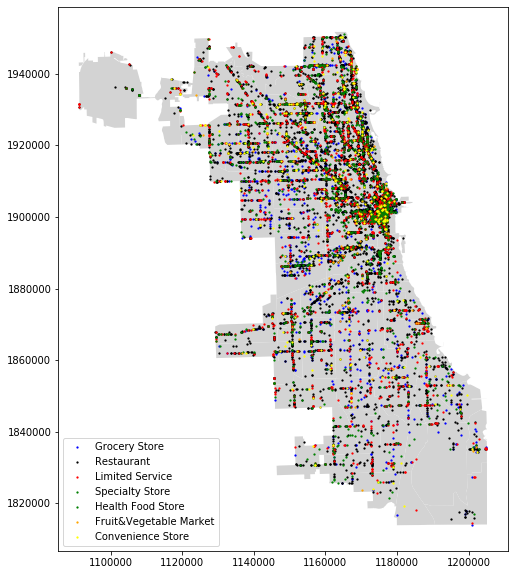

In [33]:
#FOR PLOTTING - RUNS ONE STEP OF THE MODEL
fig, ax= plt.subplots(figsize=(10, 10))
chicago.plot(ax=ax, color="lightgrey")
#model = FVModel(number of PA, FS distance, friend distance, budget stretch preference range (BSPR), within budget pref range (WBPR) plot info)
model = FVModel(2710, 2000, 5000, 0.02, 0.10, fig_ax = (fig, ax))
#for i in range(50):
model.step()
plt.savefig("FoodStoreAgents_09092021.png")

In [30]:
plt.savefig("PersonAgents_09092021.png", dpi=100)
plt.show()

<Figure size 432x288 with 0 Axes>

In [34]:
#Batch Runner
#COUNTS OF FV OVER THE STUDY PERIOD (1 WEEK)
fixed_params = {"FS_distance": 5280,
               "PA_distance": 5280,
               "BSPR": 0.02,
               "WBPR": 0.10}
variable_params = {"N": range(20000, 120000, 20000)} #0.1% to 10% Chicago pop, step halfway between
model_reporters = {"Count_FV_W": lambda m: FVModel.Count_TotFV(m, "White"),
                  "Count_FV_B": lambda m: FVModel.Count_TotFV(m, "Black"),
                  "Count_FV_H": lambda m: FVModel.Count_TotFV(m, "Hispanic"),
                  "Count_FV_A": lambda m: FVModel.Count_TotFV(m, "Asian"),
                  "Count_N_W": lambda m: FVModel.Count_Race_N(m, "White"),
                  "Count_N_B": lambda m: FVModel.Count_Race_N(m, "Black"),
                  "Count_N_H": lambda m: FVModel.Count_Race_N(m, "Hispanic"),
                  "Count_N_A": lambda m: FVModel.Count_Race_N(m, "Asian")} 

In [9]:
#Batch Runner
#NUMBER OF POPULATION THAT MET GOAL OF 5 FV DAILY
fixed_params = {"PA_distance": 5280,
               "BSPR": 0.02,
               "WBPR": 0.10,
               "N": 27100}
variable_params = {"FS_distance": range(5280, 26400, 5280)} #1 mile to 3 miles by 1 mile increments
model_reporters = {"Meet_Goal": lambda m: FVModel.Meet_Goal(m),
                  "Meet_Goal_W": lambda m: FVModel.Meet_Goal_Race(m, "White"),
                  "Meet_Goal_B": lambda m: FVModel.Meet_Goal_Race(m, "Black"),
                  "Meet_Goal_H": lambda m: FVModel.Meet_Goal_Race(m, "Hispanic"),
                  "Meet_Goal_A": lambda m: FVModel.Meet_Goal_Race(m, "Asian"),
                  "Count_N_W": lambda m: FVModel.Count_Race_N(m, "White"),
                  "Count_N_B": lambda m: FVModel.Count_Race_N(m, "Black"),
                  "Count_N_H": lambda m: FVModel.Count_Race_N(m, "Hispanic"),
                  "Count_N_A": lambda m: FVModel.Count_Race_N(m, "Asian")} 

In [13]:
#Batch Runner
#NUMBER OF POPULATION THAT MET GOAL OF 5 FV DAILY
fixed_params = {"BSPR": 0.02,
               "WBPR": 0.10,
               "N": 27100}
variable_params = {"FS_distance": range(5280, 21120, 5280),
                  "PA_distance": range(5280, 21120, 5280)} #1 mile to 3 miles by 1 mile increments
model_reporters = {"Meet_Goal": lambda m: FVModel.Meet_Goal(m),
                  "Meet_Goal_W": lambda m: FVModel.Meet_Goal_Race(m, "White"),
                  "Meet_Goal_B": lambda m: FVModel.Meet_Goal_Race(m, "Black"),
                  "Meet_Goal_H": lambda m: FVModel.Meet_Goal_Race(m, "Hispanic"),
                  "Meet_Goal_A": lambda m: FVModel.Meet_Goal_Race(m, "Asian"),
                  "Count_N_W": lambda m: FVModel.Count_Race_N(m, "White"),
                  "Count_N_B": lambda m: FVModel.Count_Race_N(m, "Black"),
                  "Count_N_H": lambda m: FVModel.Count_Race_N(m, "Hispanic"),
                  "Count_N_A": lambda m: FVModel.Count_Race_N(m, "Asian")} 

In [19]:
#Batch Runner
#NUMBER OF POPULATION THAT MET GOAL OF 5 FV DAILY
fixed_params = {"N": 27100,
               "PA_distance": 7920,
               "BSPR": 0.03, #np.arange for floats
               "FVI": 3}
variable_params = {"FS_distance": range(2640, 5280, 2640),
                  "WBPR": np.arange(0.15, 0.30, 0.15),
                 "BS": np.arange(0.10, 0.50, 0.20)} 
model_reporters = {"Meet_Goal": lambda m: FVModel.Meet_Goal(m),
                  "Meet_Goal_W": lambda m: FVModel.Meet_Goal_Race(m, "White"),
                  "Meet_Goal_B": lambda m: FVModel.Meet_Goal_Race(m, "Black"),
                  "Meet_Goal_H": lambda m: FVModel.Meet_Goal_Race(m, "Hispanic"),
                  "Meet_Goal_A": lambda m: FVModel.Meet_Goal_Race(m, "Asian"),
                  "Count_N_W": lambda m: FVModel.Count_Race_N(m, "White"),
                  "Count_N_B": lambda m: FVModel.Count_Race_N(m, "Black"),
                  "Count_N_H": lambda m: FVModel.Count_Race_N(m, "Hispanic"),
                  "Count_N_A": lambda m: FVModel.Count_Race_N(m, "Asian")} 

In [20]:
batch_run = BatchRunner(FVModel,
                        variable_params,
                        fixed_params,
                        iterations=1,
                        max_steps=21,
                        model_reporters=model_reporters)
batch_run.run_all()


2it [7:27:38, 13429.24s/it]


In [21]:
df = batch_run.get_model_vars_dataframe()
df.head()

,FS_distance,WBPR,BS,Run,Count_N_A,Count_N_B,Count_N_H,Count_N_W,Meet_Goal,Meet_Goal_A,Meet_Goal_B,Meet_Goal_H,Meet_Goal_W,N,PA_distance,BSPR,FVI
0,2640,0.15,0.1,0,1897,8130,7858,8943,5343,443,1337,1646,1917,27100,7920,0.03,3
1,2640,0.15,0.3,1,1897,8130,7858,8943,5352,442,1378,1613,1919,27100,7920,0.03,3


In [17]:
# OUTPUT TO CSV
df.to_csv('batchrunner_fsd_wb_bs.csv')


In [ ]:
print(hello world)